https://www.sscardapane.it/teaching/reproducibledl/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/ReproducibleDeepLearning_PhDCourse

/content/drive/MyDrive/ReproducibleDeepLearning_PhDCourse


In [3]:
# !git clone https://github.com/karolpiczak/ESC-50.git

In [4]:
import torch, torchaudio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from torch import nn
from torch.nn import functional as F


In [ ]:
!pip install pytorch_lightning

In [ ]:
from pytorch_lightning.metrics import functional

In [6]:
torch.cuda.is_available()

True

##Step 1: Loading the data

In [7]:
datapath = Path('ESC-50')

In [8]:
datapath.exists() #Just to check if the path exists

True

In [9]:
csv = pd.read_csv(datapath / Path('meta/esc50.csv'))   # / concatena le path

In [10]:
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [11]:
# Vogliamo caricare gli audio per ogni riga e trasformarli in immagini. Una volta trasformati in immagini li possiamo elaborare come vogliamo. Usiamo torchaudio
# Utilizziamo MelSpectogram che è ottima per i discorsi, anche se qui non è il caso

x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0, 0], normalize = True) # Carichiamo il primo audio, normalizziamo tra 0 e 1. è un tensore bidmensionale perché c'è sia la
# codicfica audio che stereo

In [12]:
x.shape # quindi l'audio è unidimensionale, ma ha 220500 elementi

torch.Size([1, 220500])

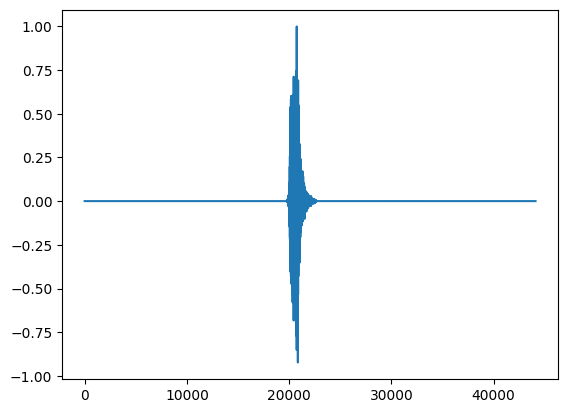

In [13]:
plt.plot(x[0, ::5])

In [14]:
torchaudio.transforms.Resample(orig_freq = sr, new_freq= 8000)(x).shape   # Quindi siamo passati da 220mila a 40mila

torch.Size([1, 40000])

In [15]:
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

/usr/local/lib/python3.9/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [16]:
h.shape # 128 è come fosse una sorta di riassunto delle frequenze. A questo punto è come se fosse un'immagine quindi la possiamo plottare

torch.Size([1, 128, 1103])

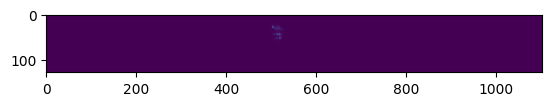

In [17]:
plt.imshow(h[0])

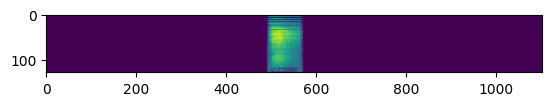

In [18]:
h = torchaudio.transforms.AmplitudeToDB()(h) #La converte in modo che sia più leggibile rispetto al grafico precedente
plt.imshow(h[0])

### Step 2: Putting together data loading and preprocessing

In [19]:
class ESC50Dataset(torch.utils.data.Dataset):
    # Simple class to load the desired folders inside ESC-50
    
    def __init__(self, path: Path = Path('ESC-50'), 
                 sample_rate: int = 8000,
                 folds = [1]):
        # Load CSV & initialize all torchaudio.transforms:
        # Resample --> MelSpectrogram --> AmplitudeToDB
        self.path = path
        self.csv = pd.read_csv(path / Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv['fold'].isin(folds)] # Since we just want the fold we care about, so we cand filter with 'fold'
        self.resample = torchaudio.transforms.Resample(
            orig_freq=44100, new_freq=sample_rate
        )
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate)
        self.db = torchaudio.transforms.AmplitudeToDB(top_db=80)
        
        
    def __getitem__(self, index):
        # Returns (xb, yb) pair, after applying all transformations on the audio file.
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path / 'audio' / row['filename'])
        label = row['target']
        xb = self.db(
            self.melspec(
                self.resample(wav)
            )
        )
        return xb, label
        
    def __len__(self):
        # Returns length
        return len(self.csv)

In [20]:
train_data = ESC50Dataset(folds=[1])

In [21]:
for xb, yb in train_data:
  break

In [22]:
xb.shape

torch.Size([1, 128, 201])

In [23]:
yb

0

###Step 3: Build a classification model

In [24]:
train_data = ESC50Dataset(folds=[1])
val_data = ESC50Dataset(folds=[2])
test_data = ESC50Dataset(folds=[3])

In [25]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True) #Utile per creare minibatch, tenere il batch_size basso se non si dispone di GPU

In [26]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [27]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)

In [28]:
class AudioNet(pl.LightningModule):
    
    def __init__(self, n_classes = 50, base_filters = 32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    def training_step(self, batch, batch_idx):
        # Very simple training loop
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return acc
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [29]:
# !pip3 install --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cpu
pl.seed_everything(0)

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


0

In [30]:
# Test that the network works on a single mini-batch
audionet = AudioNet()
xb, yb = next(iter(train_loader))
audionet(xb).shape


torch.Size([8, 50])

In [31]:
trainer = pl.Trainer(gpus=1,max_epochs=1)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(audionet, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 3.9 K 
1  | bn1   | BatchNorm2d | 64    
2  | conv2 | Conv2d      | 9.2 K 
3  | bn2   | BatchNorm2d | 64    
4  | pool1 | MaxPool2d   | 0     
5  | conv3 | Conv2d      | 18.5 K
6  | bn3   | BatchNorm2d | 128   
7  | conv4 | Conv2d      | 73.9 K
8  | bn4   | BatchNorm2d | 256   
9  | pool2 | MaxPool2d   | 0     
10 | fc1   | Linear      | 6.5 K 
---------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.450     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

NameError: ignored

In [ ]:
# TODO: implement the test loop.
trainer.test(audionet, test_loader)